# DANDI:001628 NWB tutorial

This tutorial demonstrates how to access an NWB file from [DANDI:001268](https://dandiarchive.org/dandiset/001628/draft) for the study detailed in [_"Microinvasive Probes for Monitoring Electrical and Chemical Neural Activity in Nonhuman Primates"_](https://www.biorxiv.org/content/10.1101/2025.01.30.635139v1.full.pdf).

This dataset contains in vivo FSCV and EPhys measurements from micro-invasive probes chronically implanted in the striatum of task-performing rhesus monkeys.


### Import Required Libraries

In [1]:
# Core data manipulation and analysis
import os

import h5py

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import remfile

# NWB and DANDI access
from dandi.dandiapi import DandiAPIClient
from matplotlib.ticker import ScalarFormatter
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['font.size'] = 10

# Streaming an NWB file

This section demonstrates how to stream an NWB file from the DANDI Archive using `remfile` and `pynwb`.

To access an embargoed dataset on DANDI, you will need to obtain a DANDI API key by creating an account on the [DANDI Archive](https://dandiarchive.org/) and copying the API key from your account.

See the DANDI documentation for more details:
https://docs.dandiarchive.org/user-guide-sharing/uploading-data/#storing-access-credentials

In [17]:
# Load session data from DANDI
dandiset_id = "001627"
subject_id = "Monkey-T"
session_id = "09272024"

filepath = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}_behavior+ecephys.nwb"

# This is only needed if you are accessing an embargoed dataset
# 1) Sets env var for the notebook kernel and subprocesses
os.environ["DANDI_API_KEY"] = "bc094f04154be602218836ab0c3904616347d1b1"

token = os.environ.get("DANDI_API_KEY")
with DandiAPIClient(token=token) as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)

# Create a disk cache to store downloaded data (optional)
cache_dirname = '/tmp/remfile_cache'
disk_cache = remfile.DiskCache(cache_dirname)

# open the file
rem_file = remfile.File(s3_url, disk_cache=disk_cache)
h5py_file = h5py.File(rem_file, "r")
io = NWBHDF5IO(file=h5py_file)
# read the NWB file
nwbfile = io.read()

## Read NWB file from local path

Alternative: You can also read the NWB file from a local path using `pynwb.read_nwb()`.

In [2]:
from pynwb import read_nwb

# Example session with FSCV data
nwbfile_path = "/Users/weian/data/Schwerdt/nwbfiles/microinvasiveProbes_manuscript/sub-Monkey-T_ses-09132024.nwb"
nwbfile = read_nwb(nwbfile_path)

### Session start time

All timestamps in the NWB file are represented as relative times (in seconds) from the session start time.
The session start time is set to the time when the **Neuralynx** system began recording, which is
`2024-09-13 09:03:06` in this example session:

In [3]:
print(nwbfile.session_start_time)

2024-09-13 09:03:06-04:00


# Subject

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWBFile.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.

In [4]:
nwbfile.subject

subject pynwb.file.Subject at 0x5258827424
Fields:
  age: P11Y
  age__reference: birth
  description: Two adult female rhesus monkeys were used for in vivo validation of the s-µIP device, with chronic implants targeting the striatum for simultaneous FSCV and EPhys recordings during behavioral tasks.
  sex: F
  species: Macaca mulatta
  subject_id: Monkey T

# Access Raw Data

This section demonstrates how to access the raw `FSCV` data.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## Raw FSCV

We implemented [ndx-fscv](https://github.com/catalystneuro/ndx-fscv) extension to store continuous FSCV data in NWB format.

### FSCVResponseSeries

The continuous raw signal (measured current) recorded during FSCV is stored in an `FSCVResponseSeries` object which is added to `nwbfile.acquisition`.
The data can be accessed as `nwbfile.acquisition["fscv_response_series"]`.

The data in `fscv_response_series` is stored as a two dimensional array: the first dimension is time, the second dimension represents electrodes/channels.

Fields / Attributes:
- `electrodes` — link to the electrodes table
- `unit` — the unit of the measured current (e.g., 'amperes')
- `current_to_voltage_factor` — optional conversion factor that can be used to convert the recorded current back to voltage
- `excitation_series` — link to the FSCVExcitationSeries that defines the applied triangular voltage

### FSCVExcitationSeries

The applied triangular voltage waveform during FSCV is stored in an `FSCVExcitationSeries` object which is added to `nwbfile.stimulus`.
The data can be accessed as `nwbfile.stimulus["fscv_excitation_series"]`.
The data in `fscv_excitation_series` is stored as a one dimensional array representing the applied voltage over time.

Fields / Attributes:
- `unit` — the unit of the applied voltage (e.g., 'volts')
- `sweep_rate` — The voltage sweep rate during a single scan, in volts per second. This represents the rate of potential change within each scan (e.g. 400 V/s)
- `scan_frequency` — The frequency at which the excitation waveform (e.g. 10 Hz)
- `waveform_shape` — The shape of the applied waveform (e.g. 'Triangle')

In [4]:
response_series = nwbfile.acquisition["fscv_response_series"]

print("=== RAW FSCV ===\n")
print("=== FSCVResponseSeries ===")
print(f"Description: {response_series.description}")
print(f"Data shape: {response_series.data.shape}")
print("Electrodes:")
print(response_series.electrodes[:].to_markdown())

excitation_series = nwbfile.stimulus["fscv_excitation_series"]

print("=== FSCVExcitationSeries ===")
print(f"Description: {excitation_series.description}")
print(f"Data shape: {excitation_series.data.shape}")
print(f"Sweep rate: {excitation_series.sweep_rate} V/s")
print(f"Scan frequency: {excitation_series.scan_frequency} Hz")
print(f"Waveform shape: {excitation_series.waveform_shape}")


=== RAW FSCV ===

=== FSCVResponseSeries ===
Description: FSCV response current before background subtraction.
Data shape: (51616800,)
Electrodes:
|   id | location   | group                                                           | group_name         |
|-----:|:-----------|:----------------------------------------------------------------|:-------------------|
|    0 | c8dg       | FSCVElectrodeGroup pynwb.ecephys.ElectrodeGroup at 0x6045291184 | FSCVElectrodeGroup |
|      |            | Fields:                                                         |                    |
|      |            |   description: The electrode group for the FSCV electrodes.     |                    |
|      |            |   device: device_ecephys pynwb.device.Device at 0x6045290176    |                    |
|      |            | Fields:                                                         |                    |
|      |            |   description: Neuralynx recording                              |   

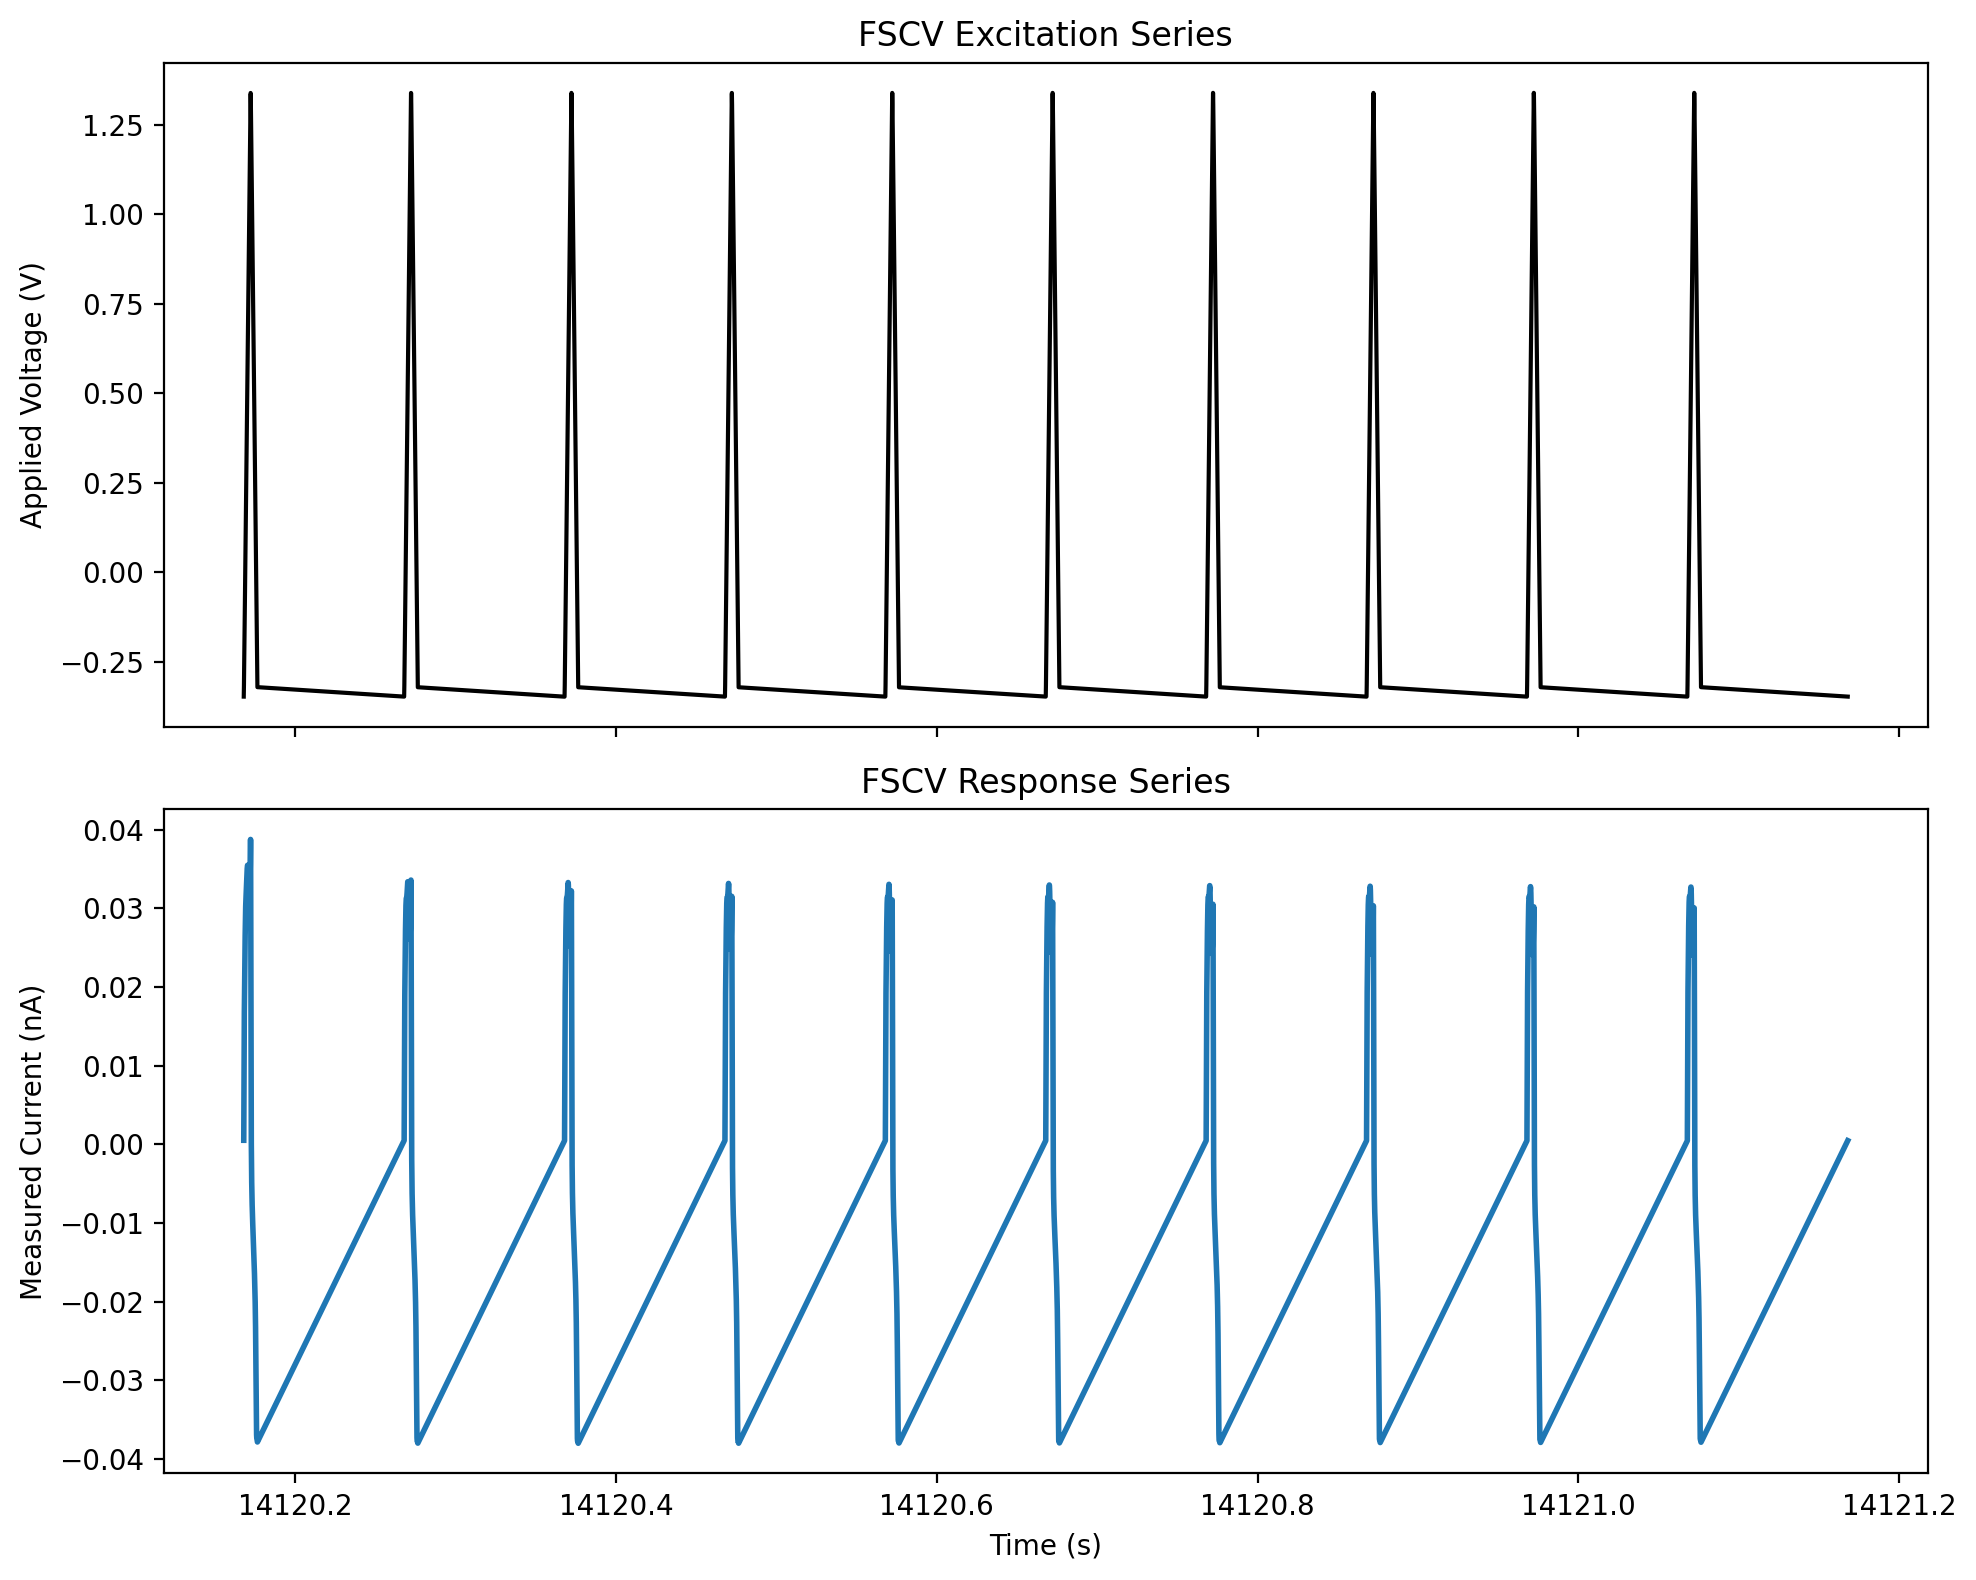

In [5]:
current_data = np.array(response_series.data)  # shape: (n_samples, n_electrodes) or (n_samples,)
voltage_data = np.array(excitation_series.data)  # shape: (n_samples,)
timestamps = np.array(response_series.timestamps)

idx = np.where((timestamps >= 14120.167919) & (timestamps <= 14121.167919))[0]

t_window = timestamps[idx]
v_window = voltage_data[idx]
c_window = current_data[idx]

fig, (ax_voltage, ax_current) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, dpi=200)
ax_voltage.plot(t_window, v_window, color="black")
ax_voltage.set_ylabel("Applied Voltage (V)")
ax_voltage.set_title("FSCV Excitation Series")

num_electrodes = c_window.shape[1] if c_window.ndim > 1 else 1
if num_electrodes == 1:
    c_window = c_window[:, np.newaxis]  # Make it 2D for consistency

electrode_labels = response_series.electrodes["id"]
colors = plt.get_cmap("tab10")(np.arange(num_electrodes) % 10)
for i in range(num_electrodes):
    ax_current.plot(
        t_window,
        c_window[:, i],
        color=colors[i],
        linewidth=2,
        label=f"Electrode{electrode_labels[i]}",
    )
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_current.xaxis.set_major_formatter(formatter)
ax_current.set_ylabel("Measured Current (nA)")
ax_current.set_title("FSCV Response Series")
ax_current.set_xlabel("Time (s)")
if num_electrodes > 1:
    plt.legend(loc="upper right")
    formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_current.xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

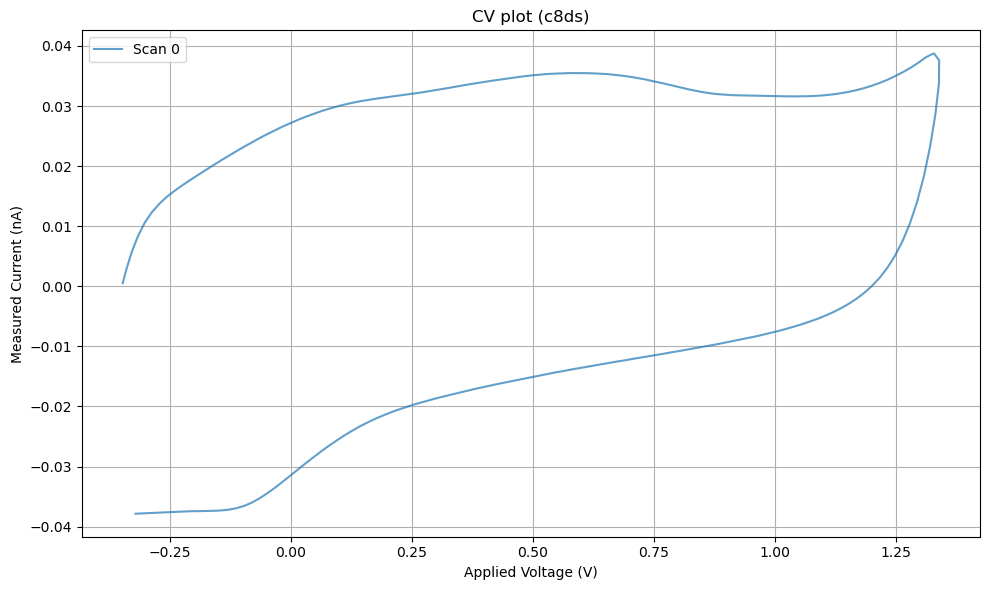

In [46]:
scans_per_second = float(excitation_series.scan_frequency)
total_samples = current_data.shape[0]

samples_per_scan = int(len(current_data) // (round(timestamps[-1] - timestamps[0]) * scans_per_second))
number_of_scans = total_samples // samples_per_scan

num_scans = 1
start_scan_index = 0

# Prepare data for plotting
num_electrodes = current_data.shape[1] if current_data.ndim > 1 else 1
if num_electrodes == 1:
    current_data = current_data[:, np.newaxis]

electrode_labels = response_series.electrodes["id"][:]
colors = plt.get_cmap("tab10")(np.arange(num_scans) % 10)

fig, axes = plt.subplots(num_electrodes, 1, figsize=(10, 6 * num_electrodes), sharex=True, sharey=True)
if num_electrodes == 1:
    axes = [axes]

for e in range(num_electrodes):
    ax = axes[e]
    for s in range(num_scans):
        scan_idx = start_scan_index + s
        start = scan_idx * samples_per_scan
        end = start + samples_per_scan
        voltage_scan = voltage_data[start:end]
        current_scan = current_data[start:end, e]
        ax.plot(voltage_scan, current_scan, color=colors[s], alpha=0.7, label=f"Scan {scan_idx}")
    ax.set_title(f"CV plot (c8ds)")

    ax.set_ylabel("Measured Current (nA)")
    ax.legend(loc="best")
    ax.grid()
ax.set_xlabel("Applied Voltage (V)")
plt.tight_layout()
plt.show()

The electrodes table describe the electrodes that generated this data. Extracellular electrodes are stored in an "electrodes" table, which is a [DynamicTable](https://hdmf.readthedocs.io/en/stable/hdmf.common.table.html#hdmf.common.table.DynamicTable) and can be can be converted to a pandas DataFrame for convenient analysis using `nwbfile.electrodes.to_dataframe()`.

In [6]:
nwbfile.electrodes.to_dataframe()

,location,group,group_name
id,,,
0,c8dg,FSCVElectrodeGroup pynwb.ecephys.ElectrodeGrou...,FSCVElectrodeGroup


## Trial-aligned FSCV signals

Trial-aligned FSCV signals (such as dopamine, pH, motion, and oxidation current) are stored in the NWB file using a `TimeIntervals` table within a processing module named "fscv". Each row of the table corresponds to a trial, with `start_time` and `stop_time` matching the trial's interval. Additional columns store the trial-aligned signals and metadata for each trial:

- `good`: Whether the FSCV data for that trial is considered good quality.
- `da`: PCA extracted dopamine concentration time series.
- `ph`: pH change time series.
- `m`: Motion artifact time series.
- `iox`: Measured oxidation current at 0.6 V.

The module can be accessed as `nwbfile.processing["fscv"]`.
Within this processing module we can access the table as `nwbfile.processing["fscv"]["trial_aligned_fscv_table"]`.

In [10]:
derived_signals_table = nwbfile.processing["fscv"]["trial_aligned_fscv_table"]
derived_signals_table[:]

,start_time,stop_time,rate,good,da,ph,m,iox
id,,,,,,,,
0,14090.167919,14150.167919,10.0,True,"[-4.716764177496725, -3.8684478584821376, -3.0...","[-0.12794633899871274, -0.1287456320308777, -0...","[0.030168447380570687, 0.023076218113614447, 0...","[0.170866842925534, 0.1809130268758281, 0.1880..."
1,14104.596687,14164.596687,10.0,True,"[-3.7806598841841152, -3.1386819836387607, -2....","[-0.035546574913595086, -0.04413364109361737, ...","[-0.03435001489762923, -0.04292514110368932, -...","[-0.18714846028456122, -0.16995782714002416, -..."
2,14112.777150,14172.777150,10.0,True,"[6.394203328501755, 5.534976018079785, 4.48153...","[-0.12618829124873407, -0.12228786731316021, -...","[0.012912949927061655, 0.02425242125218241, 0....","[0.2835887754504256, 0.2815855051255767, 0.274..."
3,14127.455969,14187.455969,10.0,True,"[2.585330642191573, 2.0394377310737397, 1.4150...","[-0.39525457293125427, -0.3911207210865764, -0...","[0.1151509178472629, 0.11594273638659681, 0.11...","[-0.022506837013679615, -0.011668286630651892,..."
4,14135.819853,14195.819853,10.0,True,"[4.8972812572406985, 5.676941400663209, 6.3959...","[0.06872928473815025, 0.06977583279265218, 0.0...","[-0.0621475765584086, -0.06812806300432069, -0...","[0.042585340861364784, 0.05567285079496287, 0...."
...,...,...,...,...,...,...,...,...
729,23721.424027,23781.424027,10.0,True,"[2.1710871352011996, 2.616802084097405, 2.7464...","[0.04139639744817467, 0.022864273018874007, 0....","[-0.012663750566901711, -0.01973531101625218, ...","[-0.04542833626851461, -0.03893919216523045, -..."
730,23736.419109,23796.419109,10.0,True,"[-0.07936953876709464, -0.5572255506633704, -1...","[0.08991303494302745, 0.08759020567931303, 0.0...","[-0.043091483296134395, -0.03766354934786553, ...","[-0.04538097308648048, -0.042029167962709835, ..."
731,23746.999062,23806.999062,10.0,True,"[0.613565607297072, 0.43024719289323177, 0.063...","[0.3188792360955353, 0.3189147093937232, 0.318...","[-0.1303811687540295, -0.12724308698200565, -0...","[-0.13418402883200997, -0.14176506391197563, -..."


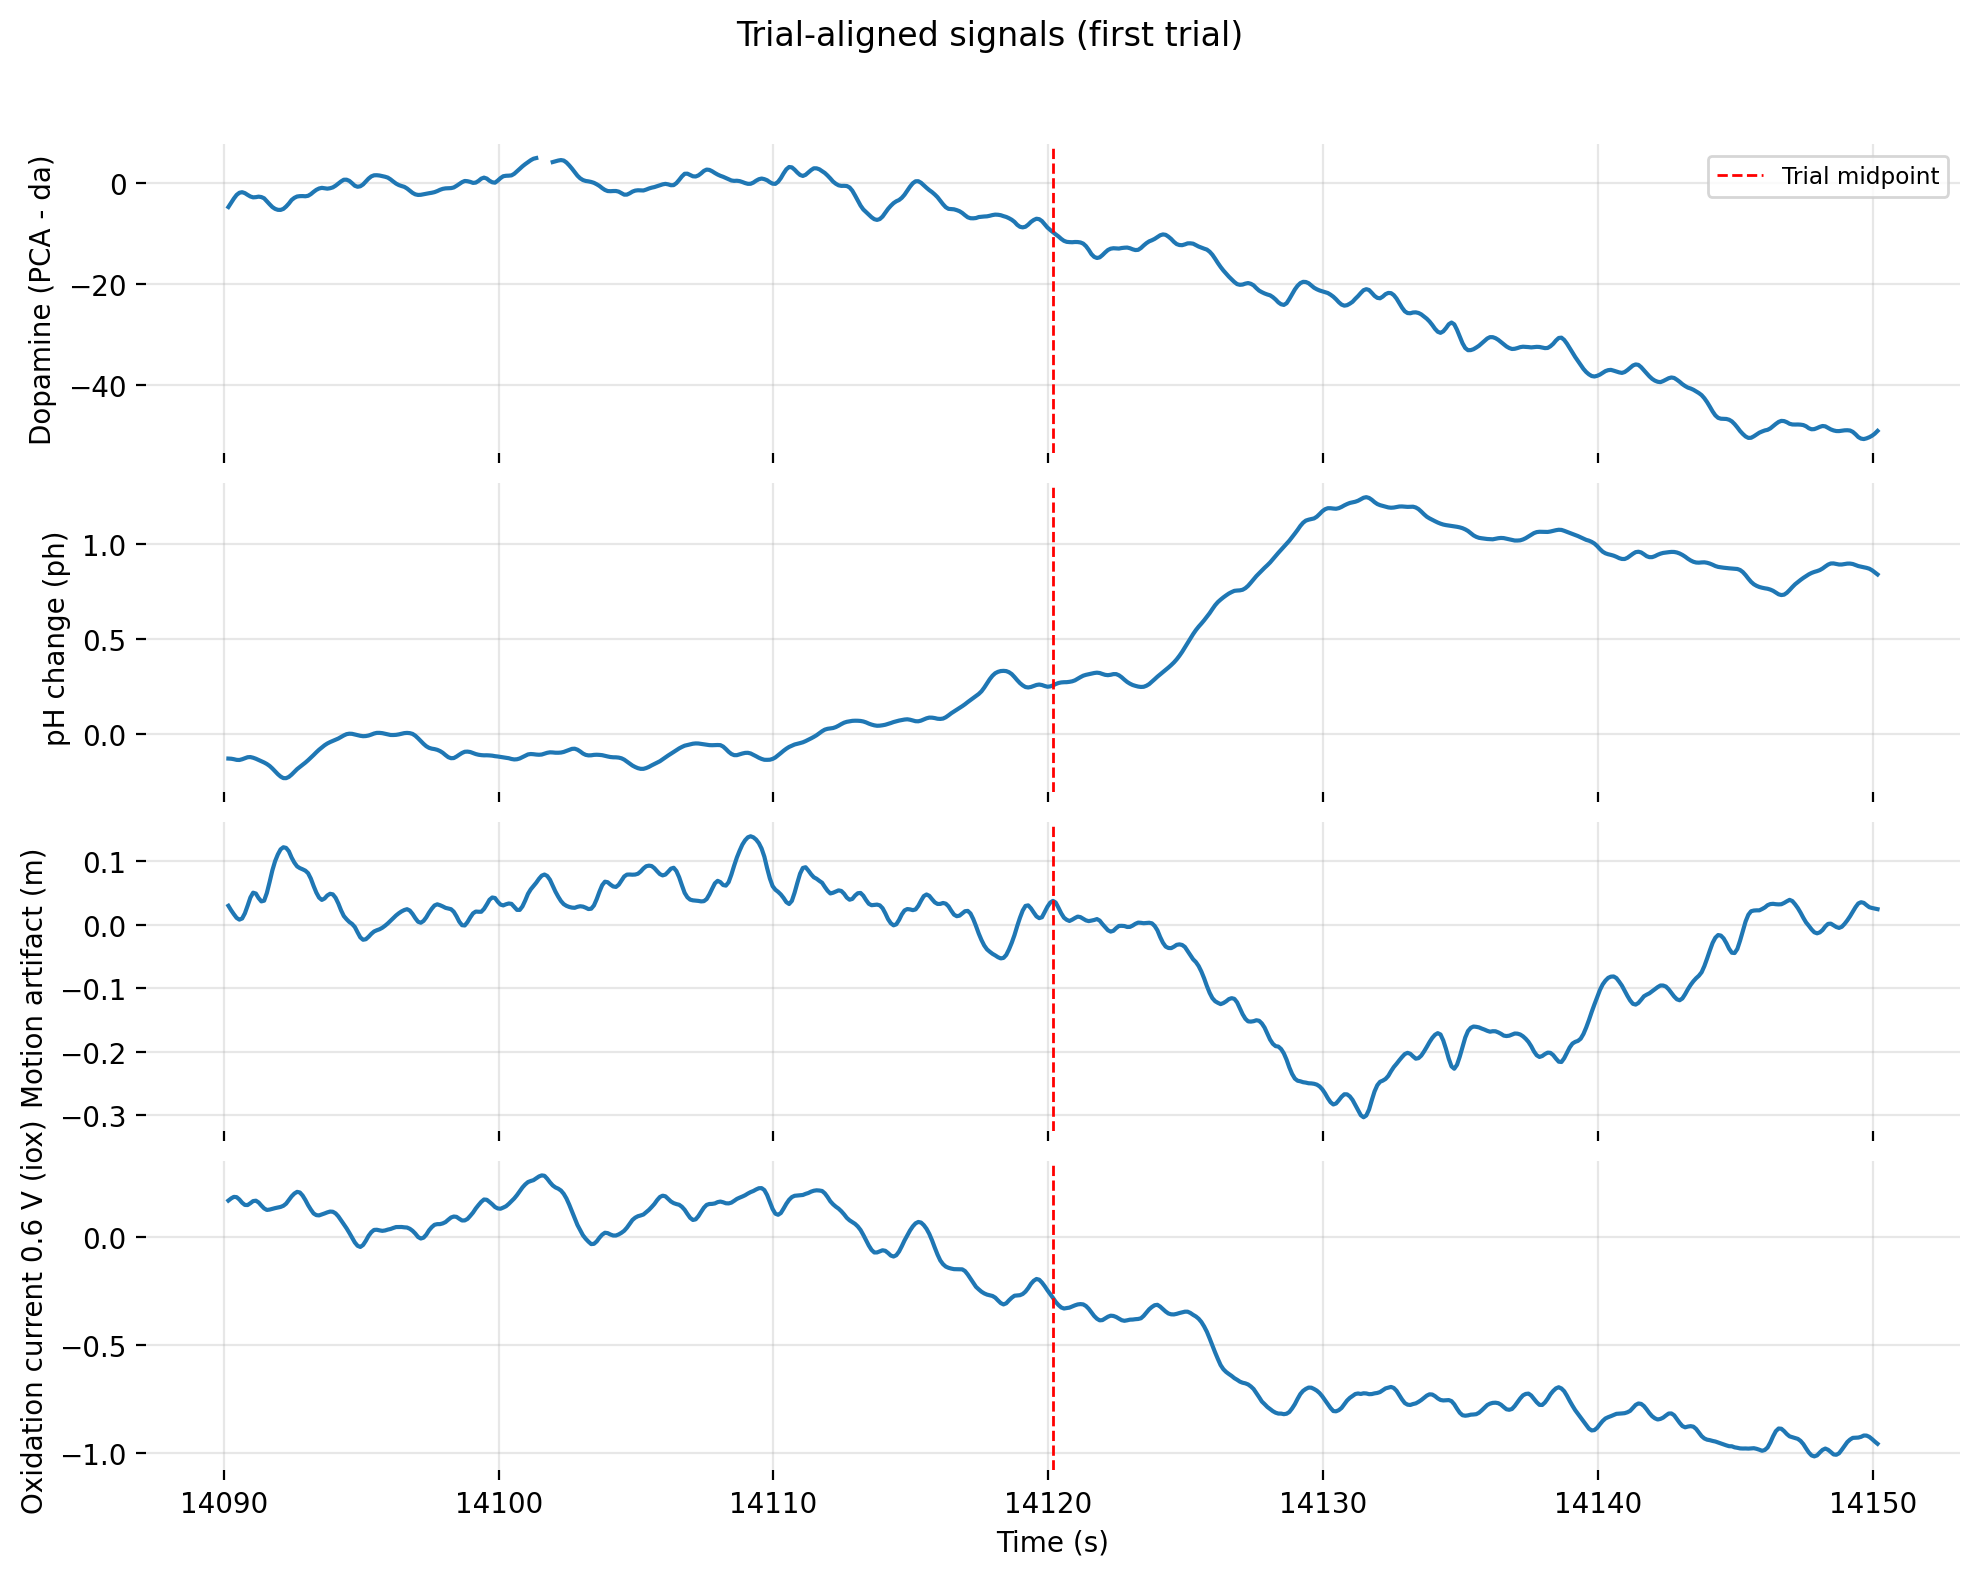

In [33]:
# trial timing
trial_start = nwbfile.trials["start_time"][0]
trial_stop = nwbfile.trials["stop_time"][0]
trial_midpoint = nwbfile.trials["midpoint_time"][0]

# derived signals table
table = derived_signals_table

signals = ["da", "ph", "m", "iox"]
label_map = {
    "da": "Dopamine (PCA - da)",
    "ph": "pH change (ph)",
    "m": "Motion artifact (m)",
    "iox": "Oxidation current 0.6 V (iox)",
}

fig, axes = plt.subplots(len(signals), 1, figsize=(10, 8), sharex=True, dpi=200)

for index, (ax, sig) in enumerate(zip(axes, signals)):
    col = table[sig]

    # get first-trial data
    sig_arr = np.array(col[0])

    # timestamps for this signal
    timestamps = np.linspace(trial_start, trial_stop, len(sig_arr))

    ax.plot(timestamps, sig_arr, color="C0", lw=1.5)
    ax.axvline(x=trial_midpoint, color="red", linestyle="--", linewidth=1, label="Trial midpoint" if index == 0 else "")
    ax.set_ylabel(label_map.get(sig, sig))
    ax.grid(alpha=0.3)
    if index == 0:
        ax.legend(loc="upper right", fontsize="small")
    ax.set_frame_on(False)

axes[-1].set_xlabel("Time (s)")
plt.suptitle("Trial-aligned signals (first trial)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Raw Eye Tracking

Raw eye-tracking signals recorded by the Neuralynx system are imported and stored in the NWB acquisition as an `EyeTracking`
container containing one `SpatialSeries` that stores the continuous gaze position time series (x, y).


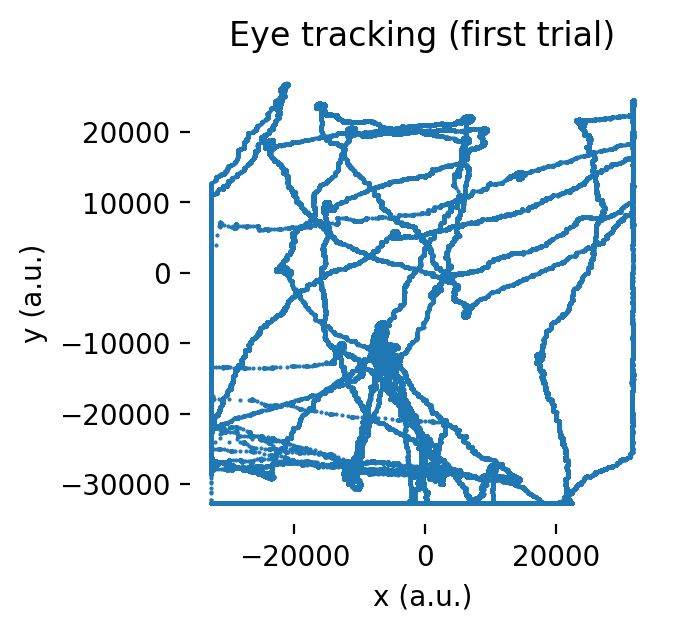

In [8]:
eye_tracking = nwbfile.acquisition["EyeTracking"]
eye_tracking_series = eye_tracking["eye_tracking_series"]

data = np.array(eye_tracking_series.data)
rate = float(eye_tracking_series.rate)

trial_start = nwbfile.trials["start_time"][0]
trial_stop = nwbfile.trials["stop_time"][0]

plt.figure(figsize=(3,3), dpi=200)

plt.plot(data[int(rate*trial_start):int(rate*trial_stop), 0], data[int(rate*trial_start):int(rate*trial_stop),1], '.', markersize=1)
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.title('Eye tracking (first trial)')
plt.gca().set_frame_on(False)
plt.show()

# Trials

The trials can be accessed as `nwbfile.trials` and can be converted to pandas DataFrame as `nwbfile.trials.to_dataframe()`

In [9]:
nwbfile.trials.to_dataframe()

,start_time,stop_time,midpoint_time,tags
id,,,,
0,14090.167919,14150.167919,14120.167919,[initial cue display]
1,14104.596687,14164.596687,14134.596687,[initial cue display]
2,14112.777150,14172.777150,14142.777150,[initial cue display]
3,14127.455969,14187.455969,14157.455969,[initial cue display]
4,14135.819853,14195.819853,14165.819853,[initial cue display]
...,...,...,...,...
1463,32833.390303,32893.390303,32863.390303,[initial cue display]
1464,32841.104481,32901.104481,32871.104481,[initial cue display]
1465,32854.150220,32914.150220,32884.150220,[initial cue display]


# Events

The events are added to processing module named "events" which can be accessed as `nwbfile.processing["events"]`.

The table can be accessed as `events["events_table"][:]`, where the `"event_times"` are populated from `NlxEventTS`, the description of the event contains the code from `NlxEventTTL`.


In [10]:
events = nwbfile.processing["events"]
# Get the events table
events_table = events["events_table"][:]

events_table

,event_times,label,event_description
id,,,
0,"[14120.167919, 14134.596687, 14142.77715, 1412...",trial start,The event times for code '128'.
1,"[14120.1682, 14120.1682, 14120.1682, 14192.277...",transient value condition,The event times for code '115'.
2,"[14120.16845, 14120.16845, 14120.16845, 14291....",right condition,The event times for code '118'.
3,"[14120.168731, 14134.596969, 14142.7774, 14120...",image 1,The event times for code '81'.
4,"[14120.169013, 14134.5975, 14142.777931, 14120...",right cue reward condition 1,The event times for code '35'.
5,"[14120.169263, 14120.169263, 14120.169263, 141...",forced trial condition,The event times for code '119'.
6,"[14120.169544, 14120.169544, 14120.169544, 141...",onedr,The event times for code '28'.
7,"[14120.634419, 14143.293884, 14120.634419, 141...",central cue fixation started,The event times for code '50'.
8,"[14122.067516, 14122.067516, 14122.067516, 141...",value object start,The event times for code '23'.


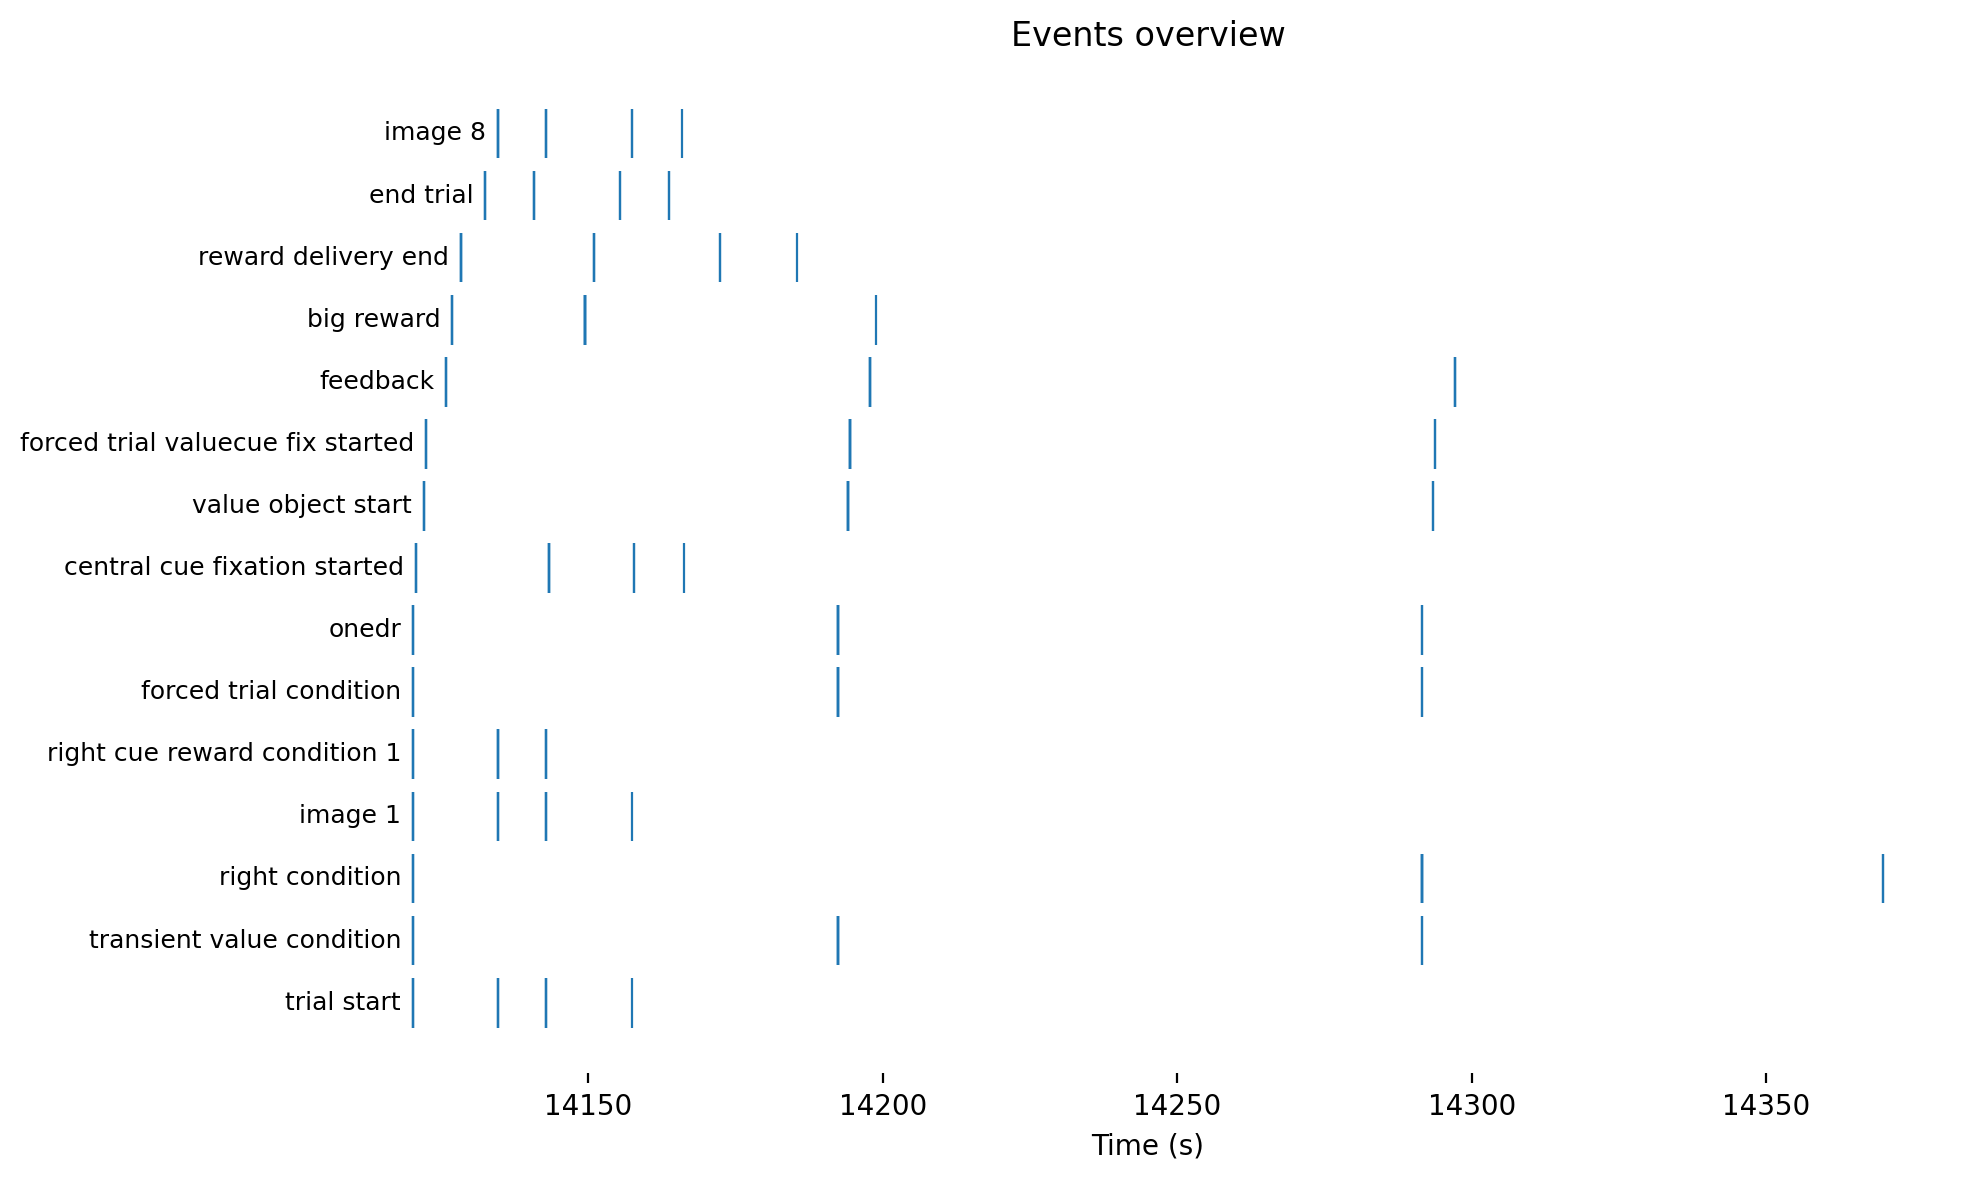

In [26]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6), dpi=200)

for i, row in events_table.head(15).iterrows():
    label = row["label"]
    times = np.array(row["event_times"])[:10]
    plt.vlines(times, i + 0.6, i + 1.4, lw=0.8)
    plt.text(times.min() - 2, i + 1, label, va="center", ha="right", fontsize=9)

plt.xlabel("Time (s)")
plt.ylabel("Event label")
plt.title("Events overview")
plt.yticks([])
plt.tight_layout()
plt.gca().set_frame_on(False)   # remove the frame
plt.ylabel("")
plt.show()
